In [113]:
import numpy as np
import sympy as sp
import control as ct
import matplotlib.pyplot as plt

### Sistema <h3>

In [114]:
# Sistema

numG = [0, 0, 0.37]
denG = [10, 1, 0]
G = ct.tf(numG, denG)
print("G(s) =")
G

G(s) =


TransferFunction(array([0.37]), array([10,  1,  0]))

### Range de 'zeros' do controlador <h3>

In [115]:
# Determinação do range de "zeros" (z) do controlador

Z = np.arange(0, -0.26, -0.01)

### Função de Transferência normalizada <h3>

In [116]:
# Normalização da função de transferência do sistema

num_G = np.zeros(len(numG))
den_G = np.zeros(len(denG))

for i in range(len(numG)):
    num_G[i] = numG[i]/denG[0]
    
for i in range(len(denG)):
    den_G[i] = denG[i]/denG[0]

G = ct.tf(num_G, den_G)
print("G(s) =")
G

G(s) =


TransferFunction(array([0.037]), array([1. , 0.1, 0. ]))

### Cálculo dos polos de malha aberta <h3>

In [117]:
# Raízes da malha aberta

casas_decimais = 4

den_G = den_G[::-1]

p = 0

s = sp.Symbol('s')
for i in range(len(den_G)):
    p = p + den_G[i]*s**i

den_G = den_G[::-1]

roots = sp.solve(p, s)
roots_np = np.array([float(root.evalf()) for root in roots])
roots = np.round(roots_np, casas_decimais)
print("Polos de G(s) =", roots)

Polos de G(s) = [-0.1  0. ]


### Especificações de projeto <h3>

In [118]:
# Especificações de projeto

MUP = 5
ts = 57.14

zeta = -np.log(MUP/100)/(np.sqrt(np.pi**2+np.log(MUP/100)**2))
zeta_wn = 4/ts
wn = zeta_wn/zeta

wn = round(wn, casas_decimais)
zeta = round(zeta, casas_decimais)
zeta_wn = round(zeta_wn, casas_decimais)

print("ωn =", wn)
print("ζ =", zeta)
print("ζ.ωn =", zeta_wn)

ωn = 0.1014
ζ = 0.6901
ζ.ωn = 0.07


### Determinação do polo conjugado desejado

In [119]:
# Polo conjugado desejado

s_re = -zeta_wn
s_im = wn*np.sqrt(1-zeta**2)

s_re = np.round(s_re, casas_decimais)
s_im = np.round(s_im, casas_decimais)

print("s (re) =", s_re)
print("s (im) =", s_im)

s (re) = -0.07
s (im) = 0.0734


### Cálculo do 'polo' do controlador, para diferentes 'zeros'

In [120]:
# Dados a serem armazenados
polos_C = []
zeros_C = []
ganhos_C = []
erros_p = []
erros_v = []

for z in Z:
    # Ângulo do zero do controlador
    if z == -zeta_wn:
        alpha_1 = np.pi/2
    if z > -zeta_wn:    
        alpha_1 = np.pi - np.arctan(s_im/abs((abs(z)-abs(zeta_wn))))
    if z < -zeta_wn:
        alpha_1 = np.arctan(s_im/abs((abs(z)-abs(zeta_wn))))
        
    # Ângulo do primeiro polo de G(s)
    if roots[0] == -zeta_wn:
        theta_1 = np.pi/2
    if roots[0] > -zeta_wn:
        theta_1 = np.pi - np.arctan((s_im)/(abs(abs(roots[0])-abs(zeta_wn))))
    if roots[0] < -zeta_wn:
        theta_1 = np.arctan((s_im)/(abs(abs(roots[0])-abs(zeta_wn))))

    # Ângulo do segundo polo de G(s)
    if roots[1] == -zeta_wn:
        theta_2 = np.pi/2
    if roots[1] > -zeta_wn:
        theta_2 = np.pi - np.arctan((s_im)/(abs(abs(roots[1])-abs(zeta_wn))))
    if roots[1] < -zeta_wn:
        theta_2 = np.arctan((s_im)/(abs(abs(roots[1])-abs(zeta_wn))))

    # Ângulo do polo do controlador a ser alocado 
    theta_3 = -(-np.pi - alpha_1 + theta_1 + theta_2)

    # Cálculo do polo do controlador
    if np.degrees(theta_3) == 90:
        x = 0
        p = -zeta_wn
    if np.degrees(theta_3) > 90:
        x = s_im/np.tan(np.pi-theta_3)
        p = -(zeta_wn - x)
    if np.degrees(theta_3) < 90:
        x = s_im/np.tan(theta_3)
        p = -(zeta_wn + x)

    # Função de transferência do controlador C(s)
    num_C = [1, -z]
    den_C = [1, -p]
    C = ct.tf(num_C, den_C)

    # Polo conjugado da malha fechada (polo desejado)
    s_ = s_re + s_im*1j

    # Expressão de C(s)
    num_C = num_C[::-1]
    den_C = den_C[::-1]
    num_C_expr = sum([num_C[i] * s**i for i in range(len(num_C))])
    den_C_expr = sum([den_C[i] * s**i for i in range(len(den_C))])
    C_expr = num_C_expr / den_C_expr
    C_expr_sub = C_expr.subs(s, s_)
    num_C = num_C[::-1]
    den_C = den_C[::-1]

    # Expressão de G(s)
    num_G = num_G[::-1]
    den_G = den_G[::-1]
    num_G_expr = sum([num_G[i] * s**i for i in range(len(num_G))])
    den_G_expr = sum([den_G[i] * s**i for i in range(len(den_G))])
    G_expr = num_G_expr / den_G_expr
    G_expr_sub = G_expr.subs(s, s_)
    num_G = num_G[::-1]
    den_G = den_G[::-1]

    # Cálculo de K
    K = np.abs(1/(C_expr_sub*G_expr_sub))
    K = sp.expand(K)

    # Erro de posição em regime permanente
    kp = sp.limit(C_expr*G_expr, s, 0)
    e_p = 1/(1+kp)

    # Erro de velocidade em regime permanente
    kv = sp.limit(s*C_expr*G_expr, s, 0)
    e_v = 1/(1+kv)

    # Armazenando os dados nos arrays
    polos_C.append(p)
    zeros_C.append(z)
    ganhos_C.append(K)
    erros_p.append(e_p.evalf())
    erros_v.append(e_v.evalf())

    # Printando os dados
    print("z =", round(z,4), "===", "p =", round(p,4), "===", "K =", round(K,4), "===", "ep =", round(e_p.evalf(),4), "===", "ev =", round(e_v.evalf(),4))

z = 0.0 === p = -0.04 === K = 0.1699 === ep = 0.0976 === ev = 1.00000000000000
z = -0.01 === p = -0.0464 === K = 0.1768 === ep = 0 === ev = 0.9261
z = -0.02 === p = -0.0533 === K = 0.1843 === ep = 0 === ev = 0.8780
z = -0.03 === p = -0.0608 === K = 0.1924 === ep = 0 === ev = 0.8455
z = -0.04 === p = -0.0689 === K = 0.2012 === ep = 0 === ev = 0.8233
z = -0.05 === p = -0.0779 === K = 0.2109 === ep = 0 === ev = 0.8082
z = -0.06 === p = -0.0878 === K = 0.2216 === ep = 0 === ev = 0.7982
z = -0.07 === p = -0.0988 === K = 0.2335 === ep = 0 === ev = 0.7923
z = -0.08 === p = -0.111 === K = 0.2467 === ep = 0 === ev = 0.7894
z = -0.09 === p = -0.1246 === K = 0.2614 === ep = 0 === ev = 0.7891
z = -0.1 === p = -0.14 === K = 0.2780 === ep = 0 === ev = 0.7910
z = -0.11 === p = -0.1575 === K = 0.2969 === ep = 0 === ev = 0.7946
z = -0.12 === p = -0.1775 === K = 0.3186 === ep = 0 === ev = 0.7999
z = -0.13 === p = -0.2007 === K = 0.3436 === ep = 0 === ev = 0.8066
z = -0.14 === p = -0.2278 === K = 0.3729 

### Escolha do melhor controlador <h3>

#### A escolha é baseada no menor erro de posição e de velocidade. Como se trata do controle de posição de um motor, prioriza-se o erro de posição <h4>

In [121]:
# Escolha do melhor controlador

best_id = 0

min_value_p = np.min(erros_p)
min_id_p = []

for i in range(len(Z)):
    if erros_p[i] == min_value_p:
        min_id_p.append(i)

min_value_v = 1000
for i in min_id_p:
    if erros_v[i] < min_value_v:
        min_value_v = erros_v[i]
        best_id = i

best_K = ganhos_C[best_id]
best_p = polos_C[best_id]
best_z = zeros_C[best_id]

num_Cs = np.array([1, -best_z])
den_Cs = np.array([1, -best_p])

print("Função de transferência do controlador escolhido:")
C_s = ct.tf(num_Cs, den_Cs)
C_s = float(best_K) * C_s
C_s

Função de transferência do controlador escolhido:


TransferFunction(array([0.26141175, 0.02352706]), array([1.        , 0.12461687]))

### Resposta ao degrau com o melhor controlador <h3>

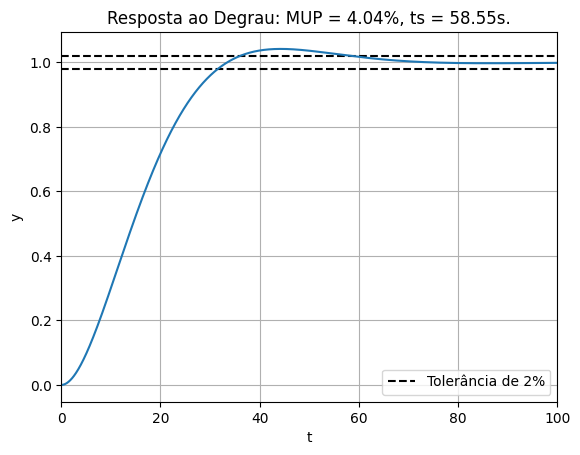

In [122]:
# Resposta ao degrau

time = np.arange(0, 100, 0.01)
MF = (G*C_s)/(1+(G*C_s))
t, y = ct.step_response(MF, T=time)

# Máximo sobressinal
MUP_real = ((np.max(y)-1)/np.max(y))*100

# Tempo de acomodação
y = y[::-1]
for i in range(len(y)):
    if abs(y[i]-1) > 0.02:
        ts_real = t[len(t)-i]
        break
y = y[::-1]

plt.title('Resposta ao Degrau:' + ' MUP = ' +  str(round(MUP_real,2)) + '%,' + ' ts = ' + str(round(ts_real,2)) + 's.')
plt.axhline(0.98, color='black', linestyle='--', label='Tolerância de 2%')
plt.axhline(1.02, color='black', linestyle='--')
plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y')
plt.xlim(0,100)
plt.legend()
plt.grid()

### Especificações obtidas comparadas com as desejadas <h3>

In [123]:
print("Desejadas:")
print("ts =", ts, "s")
print("MUP =", MUP, "%")

print("Obtidas:")
print("ts =", round(ts_real, 4), "s")
print("MUP =", round(MUP_real, 4), "%")

Desejadas:
ts = 57.14 s
MUP = 5 %
Obtidas:
ts = 58.55 s
MUP = 4.0355 %
